In [10]:
import cv2
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from dataset_utils import mkdir_if_missing
from PIL import Image
from skimage import io
from tqdm import tqdm

import json
import pprint


## Converting wisdom sim dataset to cluttered omniglot format

In [19]:
DATASET_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/wisdom-sim-block-npy"
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net/fold_0003"
mkdir_if_missing(OUT_DIR)
mkdir_if_missing(os.path.join(OUT_DIR, "train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "val-one-shot"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-train"))
mkdir_if_missing(os.path.join(OUT_DIR, "test-one-shot"))

# Dataset size
NUM_IMS = 30

# input image size
IM_HEIGHT = 384
IM_WIDTH = 512

# 1:3 ratio between im_size and tar_size
IM_SIZE = 384
TAR_SIZE = 128

# Image distortion
ANGLE = 100
SHEAR = 4

# For storage purposes
BLOCK_SIZE = 1
BLOCKED = False

In [17]:
def rot_x(phi, theta, ptx, pty):
    return np.cos(phi+theta)*ptx + np.sin(phi-theta)*pty


def rot_y(phi, theta, ptx, pty):
    return -np.sin(phi+theta)*ptx + np.cos(phi-theta)*pty


def prepare_img(img, angle=100, shear=2.5, scale=2):
    # Apply affine transformations and scale characters for data augmentation
    phi = np.radians(np.random.uniform(-angle, angle))
    theta = np.radians(np.random.uniform(-shear, shear))
    a = scale**np.random.uniform(-1, 1)
    b = scale**np.random.uniform(-1, 1)
    (x, y) = img.shape
    x = a * x
    y = b * y
    xextremes = [rot_x(phi, theta, 0, 0), rot_x(phi, theta, 0, y), rot_x(phi, theta, x, 0), rot_x(phi, theta, x, y)]
    yextremes = [rot_y(phi, theta, 0, 0), rot_y(phi, theta, 0, y), rot_y(phi, theta, x, 0), rot_y(phi, theta, x, y)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)

    aff_bas = np.array([[a*np.cos(phi+theta), b*np.sin(phi-theta), -mnx], [-a*np.sin(phi+theta), b*np.cos(phi-theta), -mny], [0, 0, 1]])
    aff_prm = np.linalg.inv(aff_bas)
    pil_img = Image.fromarray(img)
    pil_img = pil_img.transform((int(mxx - mnx),int(mxy - mny)),
                                    method=Image.AFFINE,
                                    data=np.ndarray.flatten(aff_prm[0:2, :]))
    pil_img = pil_img.resize((int(TAR_SIZE * (mxx - mnx) / 100), int(TAR_SIZE * (mxy - mny) / 100)))

    return np.array(pil_img)


def bbox(im):
    # get bounding box coordinates
    rows = np.any(im, axis=1)
    cols = np.any(im, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def make_target(modal_mask, angle=0, shear=0, scale=1):
    # make target image
    transformed_mask = prepare_img(modal_mask, angle, shear, scale)
    top, bot, left, right = bbox(transformed_mask)
    obj_size = max(bot - top, right - left)
    margin = max((TAR_SIZE * 2 - obj_size) // 2, 0)
    return cv2.resize(
        transformed_mask[max(0, top - margin):min(transformed_mask.shape[0], bot + margin),
                         max(0, left - margin):min(transformed_mask.shape[1], right + margin)],
        (TAR_SIZE, TAR_SIZE),
        interpolation=cv2.INTER_NEAREST)

def resize_scene(im):
    if len(im.shape) == 2:
        im = np.pad(im, (((IM_WIDTH - IM_SIZE) // 2, (IM_WIDTH - IM_SIZE) // 2), (0, 0)), mode="constant")
    elif len(im.shape) == 3:
        im = np.pad(im, (((IM_WIDTH - IM_SIZE) // 2, (IM_WIDTH - IM_SIZE) // 2), (0, 0), (0, 0)), mode="constant")
    else:
        raise Exception("image dimensions not valid for scene/ground truth, shape: {}".format(im.shape))
    return cv2.resize(
        im,
        (IM_SIZE, IM_SIZE),
        interpolation=cv2.INTER_NEAREST)

  0%|          | 0/5 [00:00<?, ?it/s]

[  0 255]


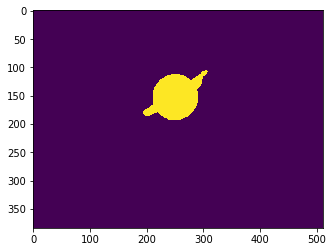

[  0 255]


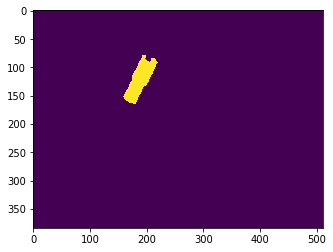

[  0 255]


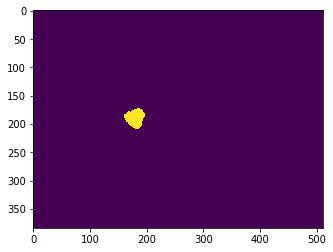

[  0 255]


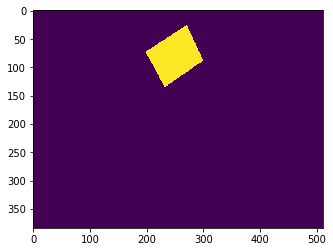

[  0 255]


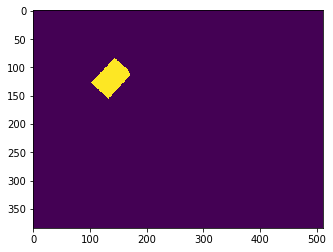

[  0 255]


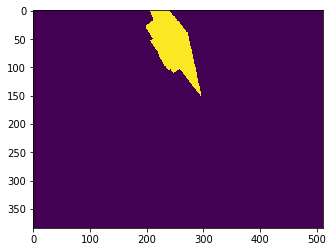

[0]


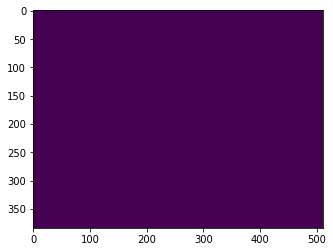

 20%|██        | 1/5 [00:01<00:05,  1.26s/it]

[  0 255]


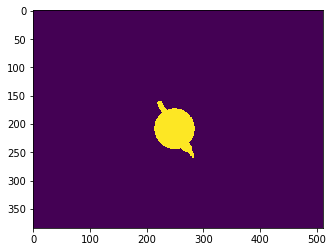

[  0 255]


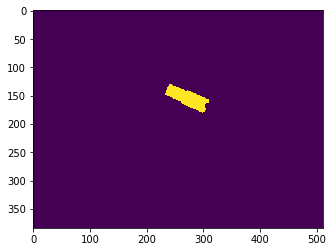

[  0 255]


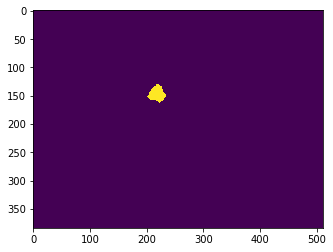

[  0 255]


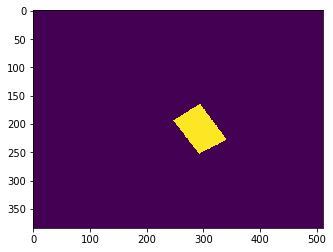

[  0 255]


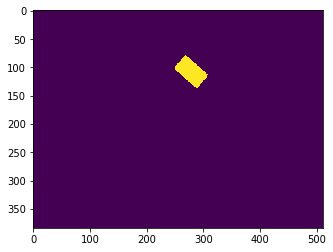

[  0 255]


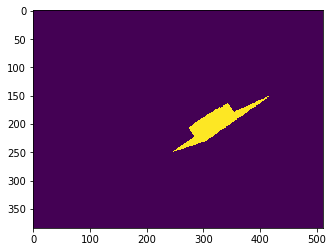

[0]


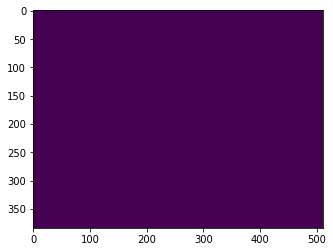

 40%|████      | 2/5 [00:02<00:03,  1.20s/it]

[  0 255]


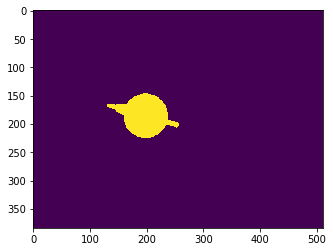

[  0 255]


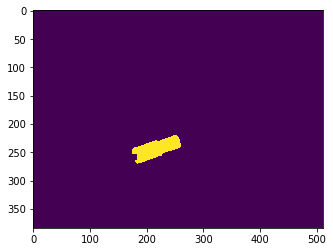

[  0 255]


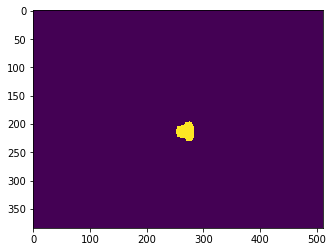

[  0 255]


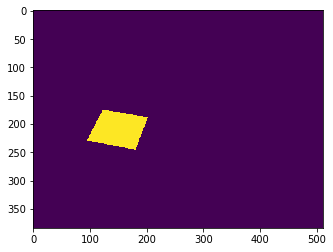

[  0 255]


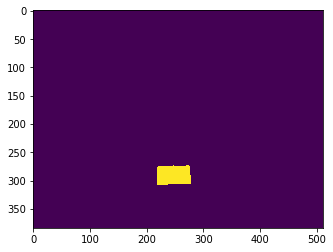

[  0 255]


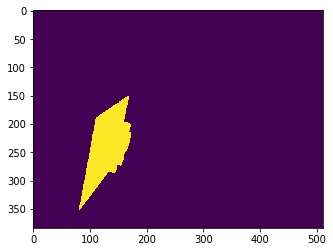

[0]


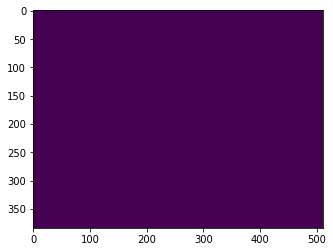

 60%|██████    | 3/5 [00:03<00:02,  1.27s/it]

[  0 255]


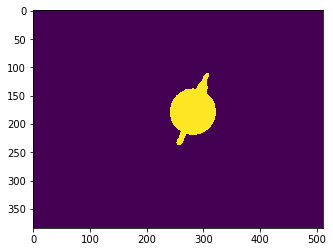

[  0 255]


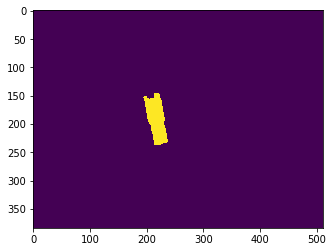

[  0 255]


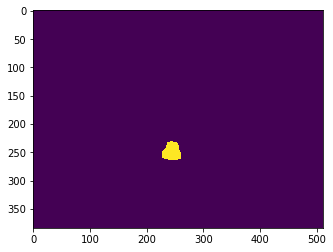

[  0 255]


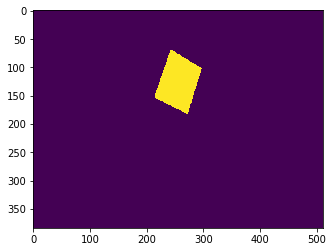

[  0 255]


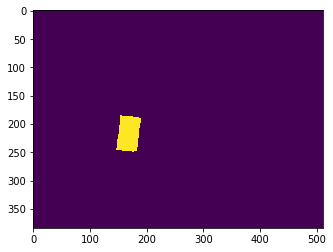

[  0 255]


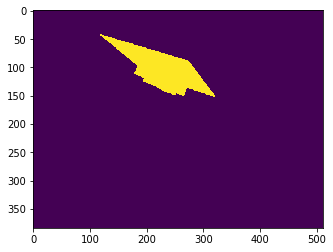

[0]


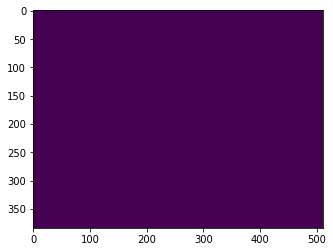

 80%|████████  | 4/5 [00:05<00:01,  1.31s/it]

[  0 255]


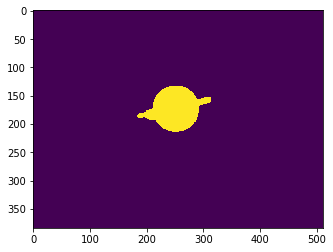

[  0 255]


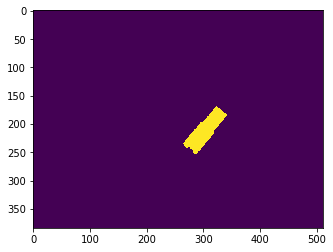

[  0 255]


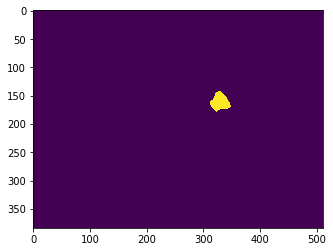

[  0 255]


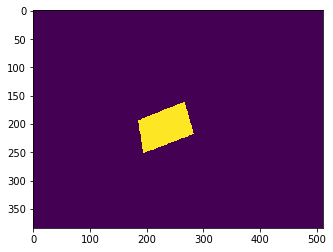

[  0 255]


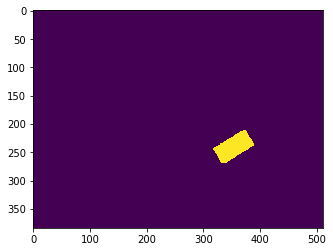

[  0 255]


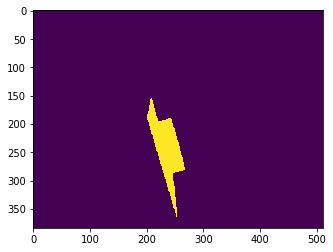

[0]


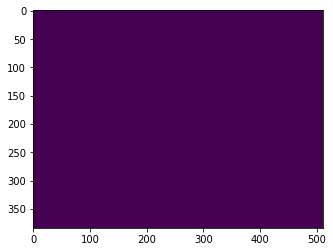

100%|██████████| 5/5 [00:06<00:00,  1.35s/it]


In [10]:
data_count = 0
train_indices = set(np.load(
    os.path.join(DATASET_DIR, "train_indices.npy")))
test_indices = set(np.load(
    os.path.join(DATASET_DIR, "test_indices.npy")))
for im_idx in tqdm(range(NUM_IMS)):
    scene_path = os.path.join(
        DATASET_DIR,
        "depth_ims",
        "image_{:06d}.png".format(im_idx))
    scene_im = io.imread(scene_path)
    
    # read and blockify scene
    scene_im = io.imread(scene_path)
    scene_im = resize_scene(scene_im)
    scene_im = np.expand_dims(scene_im, axis=0)
    
    for mask_idx in range(11):
        channel_name = "image_{:06d}_channel_{:03d}.png".format(im_idx, mask_idx)
        amodal_path = os.path.join(
            DATASET_DIR,
            "amodal_segmasks",
            channel_name)
        amodal_mask = io.imread(amodal_path)
        print(np.unique(amodal_mask))
        plt.imshow(amodal_mask)
        plt.show()
        # if there is no amodal mask, object doesn't exist.
        try:
            amodal_mask = make_target(amodal_mask, angle=ANGLE, shear=SHEAR)
            amodal_mask[amodal_mask > 0] = 1
        except:
            break

In [18]:
data_count = 0
train_indices = set(np.load(
    os.path.join(DATASET_DIR, "train_indices.npy")))
test_indices = set(np.load(
    os.path.join(DATASET_DIR, "test_indices.npy")))

train_counter = 0
test_counter = 0
test_folders = ["test-train", "test-one-shot", "val-train", "val-one-shot"]
test_counters = [0 for i in range(4)]
train_ims_block = np.zeros((BLOCK_SIZE, IM_SIZE, IM_SIZE, 3))
train_seg_block = np.zeros((BLOCK_SIZE, IM_SIZE, IM_SIZE, 1))
train_tar_block = np.zeros((BLOCK_SIZE, TAR_SIZE, TAR_SIZE, 3))
test_ims_block = np.zeros((BLOCK_SIZE, IM_SIZE, IM_SIZE, 3))
test_seg_block = np.zeros((BLOCK_SIZE, IM_SIZE, IM_SIZE, 1))
test_tar_block = np.zeros((BLOCK_SIZE, TAR_SIZE, TAR_SIZE, 3))
for im_idx in range(NUM_IMS):
    im_path = os.path.join(
        DATASET_DIR,
        "depth_ims",
        "image_{:06d}.png".format(im_idx))
    im = io.imread(im_path, as_gray=True)
    im = resize_scene(im)
    print(im_idx)
    """plt.figure()
    plt.imshow(im)"""
    for mask_idx in range(11):
        channel_name = "image_{:06d}_channel_{:03d}.png".format(im_idx, mask_idx)
        amodal_path = os.path.join(
            DATASET_DIR,
            "amodal_segmasks",
            channel_name)
        amodal_mask = io.imread(amodal_path, as_gray=True)

        # if there is no amodal mask, object doesn't exist.
        try:
            amodal_mask = make_target(amodal_mask, angle=ANGLE, shear=SHEAR)
            amodal_mask[amodal_mask > 0] = 1
        except:
            break
        """plt.figure()
        plt.imshow(amodal_mask)"""
        data_count += 1
        modal_path = os.path.join(
            DATASET_DIR,
            "modal_segmasks",
            channel_name)
        modal_mask = io.imread(modal_path, as_gray=True)
        modal_mask = resize_scene(modal_mask)
        modal_mask[modal_mask > 0] = 1
        
        """plt.figure()
        plt.imshow(modal_mask)"""
        
        if im_idx in train_indices:
            train_idx = train_counter % BLOCK_SIZE
            train_ims_block[train_idx] = np.stack((im, im, im), axis=2)
            train_seg_block[train_idx] = modal_mask[:, :, np.newaxis]
            train_tar_block[train_idx] = np.stack((amodal_mask, amodal_mask, amodal_mask), axis=2)
            if train_idx == BLOCK_SIZE - 1:
                io.imsave(os.path.join(
                    OUT_DIR,
                    "train/",
                    "image_{:08d}.png".format(train_counter // BLOCK_SIZE)),
                       train_ims_block)
                io.imsave(os.path.join(
                    OUT_DIR,
                    "train/",
                    "segmentation_{:08d}.png".format(train_counter // BLOCK_SIZE)),
                       train_seg_block)
                io.imsave(os.path.join(
                    OUT_DIR,
                    "train/",
                    "target_{:08d}.png".format(train_counter // BLOCK_SIZE)),
                       train_tar_block)
                """np.save(os.path.join(
                    OUT_DIR,
                    "train/",
                    "image_{:08d}.npy".format(train_counter // BLOCK_SIZE)),
                       train_ims_block)
                np.save(os.path.join(
                    OUT_DIR,
                    "train/",
                    "segmentation_{:08d}.npy".format(train_counter // BLOCK_SIZE)),
                       train_seg_block)
                np.save(os.path.join(
                    OUT_DIR,
                    "train/",
                    "target_{:08d}.npy".format(train_counter // BLOCK_SIZE)),
                       train_tar_block)"""
            train_counter += 1

        elif im_idx in test_indices:
            test_idx = test_counter % BLOCK_SIZE
            test_ims_block[test_idx] = np.stack((im, im, im), axis=2)
            test_seg_block[test_idx] = modal_mask[:, :, np.newaxis]
            test_tar_block[test_idx] = np.stack((amodal_mask, amodal_mask, amodal_mask), axis=2)
            if test_idx == BLOCK_SIZE - 1:
                test_folder_idx = np.random.choice([0, 1, 2, 3])
                test_folder = test_folders[test_folder_idx]
                io.imsave(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "image_{:08d}.png".format(test_counters[test_folder_idx])),
                        test_ims_block)
                io.imsave(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "segmentation_{:08d}.png".format(test_counters[test_folder_idx])),
                        test_seg_block)
                io.imsave(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "target_{:08d}.png".format(test_counters[test_folder_idx])),
                        test_tar_block)
                
                """Old, raw numpy stuff
                np.save(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "image_{:08d}.npy".format(test_counters[test_folder_idx])),
                        test_ims_block)
                np.save(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "segmentation_{:08d}.npy".format(test_counters[test_folder_idx])),
                        test_seg_block)
                np.save(os.path.join(
                    OUT_DIR,
                    test_folder,
                    "target_{:08d}.npy".format(test_counters[test_folder_idx])),
                        test_tar_block)"""
                test_counters[test_folder_idx] += 1
            test_counter += 1
print("Data count: {}".format(data_count))


0


ValueError: Invalid shape for image array: (1, 384, 384, 3)


## Converting wisdom-real json structure to cluttered omniglot dataset format

In [5]:
# input directories
AMODAL_MASK_DIR = "/nfs/diskstation/projects/mech_search/siamese_net_training/phoxi_training_dataset"
SCENE_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/wisdom/wisdom-real/high-res"
JSON_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/real_test_09_10_18/phoxi/color_ims"

# output directories
OUT_DIR = "/nfs/diskstation/projects/dex-net/segmentation/datasets/mask-net-real"


In [13]:
with open(os.path.join(JSON_DIR, "image_000001__labels.json")) as f:
    ex = json.load(f)
    pprint.pprint(ex)

{'complete': None,
 'image_filename': 'image_000001.png',
 'labels': [{'label_class': 'object',
             'label_type': 'polygon',
             'object_id': 1,
             'vertices': [{'x': 312.8100631975566, 'y': 466.04652022311114},
                          {'x': 316.05007709208473, 'y': 457.94648548679066},
                          {'x': 325.7701187756693, 'y': 452.27646117136635},
                          {'x': 336.3001639328859, 'y': 452.27646117136635},
                          {'x': 349.2602195109986, 'y': 452.27646117136635},
                          {'x': 358.1702577209511, 'y': 452.27646117136635},
                          {'x': 364.65028551000745, 'y': 462.80650632858294},
                          {'x': 367.89029940453565, 'y': 466.8565236967432},
                          {'x': 370.32030982543176, 'y': 470.9065410649034},
                          {'x': 380.0403515090163, 'y': 474.14655495943157},
                          {'x': 397.8604279289213, 'y': 480.62658

In [ ]:
test_dir = "/nfs/diskstation/dmwang/labeled_wisdom_real/dataset/image_000000"
